
# Analysis Notebook

This notebook can be used to produce graphs and analyses for the data produced. It defaults to using the latest results, but that can be specified. 
*** 

## 0. Setup <a class="anchor" id="0"></a>
This section imports all files and sets up the notebook.

In [43]:
# Import all pacakges
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [44]:
# Choose which results to use
results_to_use = [""]  # If this is empty, the last file in the folder will be used
WARMUP_EPOCHS = 30 # Number of epochs to ignore.
sim_colours = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']


all_results = os.listdir('results/')

if results_to_use == [""]:
    results_to_use = all_results

print("Using results: " + str(results_to_use))


Using results: ['full_bid_rank', 'full_inact_rank', 'random', 'adaptive']


In [45]:
# Create a dictionary. Each key is a set of results. 

all_sim_results = {}

for sim in results_to_use:
    all_sim_results[sim] = {}
    all_sim_results[sim]['configuration'] = pd.read_csv(
        'results/' + sim + '/configuration.txt', header=None, delimiter=":")
    types_of_results = []
    # Get all the filenames in the folder, excluding the extension
    for file in os.listdir('results/' + sim + '/exported_data/'):
        if file.endswith(".npy"):
            types_of_results.append(file[:-4])
    # Create a dictionary for each type of result
    for result in types_of_results:
        all_sim_results[sim][result] = np.load(
            'results/' + sim + '/exported_data/' + result + '.npy')

In [46]:
# Show all the all_sim_results in the notebook
for set_of_results in results_to_use:
    print("Results: " + set_of_results)
    print(all_sim_results[set_of_results]['configuration'])

Results: full_bid_rank
                                    0                             1
0                             command                           run
1                       num_of_epochs                          2000
2                  num_of_simulations                          1000
3                           grid_size                             3
4                      queue_capacity                            10
5                     congestion_rate                          0.07
6                      credit_balance                           inf
7                           wage_time                             1
8           shared_auction_parameters                          None
9   adaptive_auction_action_selection                          ucb1
10       adaptive_auction_update_rule                 simple_bandit
11             auction_episode_length                            10
12   action_selection_hyperparameters                          None
13    adaptive_auction_di

## 1. Satisfaction per Bidding Type <a class="anchor" id="1"></a>

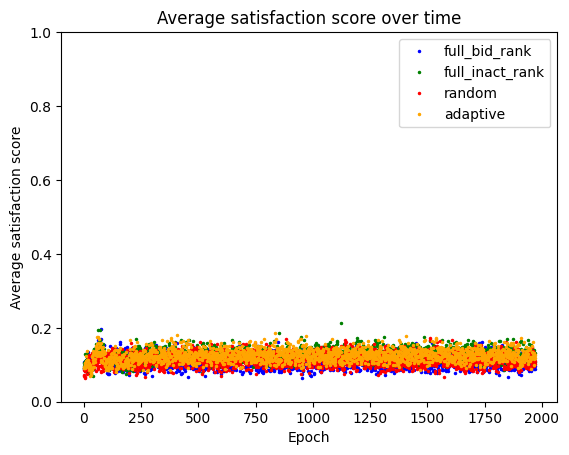

In [57]:
plt.clf()
average_satisfaction_score_results = []
for sim in results_to_use:
    average_satisfaction_score_results.append(
        all_sim_results[sim]['average_satisfaction_score'])

for i, history in enumerate(average_satisfaction_score_results):
    plt.plot(list(range(len(history))), history,
             'o', ls='none', markersize=1.5, label=results_to_use[i], color = sim_colours[i])
plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.ylabel('Average satisfaction score')
plt.title('Average satisfaction score over time')
plt.legend()
plt.show()


## 2. Average Auction Reward per Intersection

In [48]:
def plot_single_reward_history(average_reward_per_intersection, label, colour, axs):
    for i in range(average_reward_per_intersection.shape[0]):
        for j in range(average_reward_per_intersection.shape[0]):
            axs[i, j].plot(
                average_reward_per_intersection[i, j], 'o', markersize=1.5, color=colour, label=label)
            axs[i, j].set_title('[' + str(i) + str(j) + ']')
            axs[i, j].set_xlabel('Epoch')
            axs[i, j].set_ylabel('Average Auction Reward')

<Figure size 640x480 with 0 Axes>

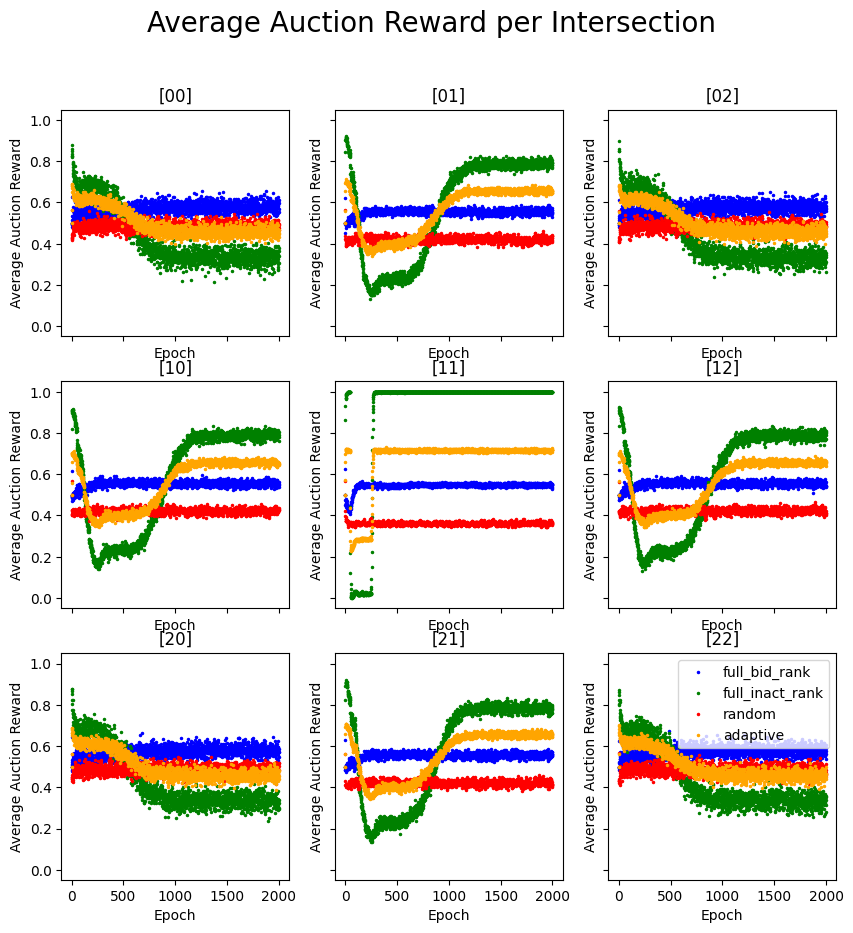

In [49]:
plt.clf()
average_reward_per_intersection_history_results = []
for sim in results_to_use:
    average_reward_per_intersection_history_results.append(
        all_sim_results[sim]['average_reward_per_intersection_history'])

fig, axs = plt.subplots(
    average_reward_per_intersection_history_results[0].shape[0], 
    average_reward_per_intersection_history_results[0].shape[1], sharex=True, sharey=True, figsize=(10, 10))

for i, history in enumerate(average_reward_per_intersection_history_results):
    plot_single_reward_history(history, results_to_use[i], sim_colours[i], axs)

fig.suptitle('Average Auction Reward per Intersection ', fontsize=20)
plt.legend()
plt.show()


## 3. Average Throughput per Intersection <a id="3"></a>

In [50]:
def plot_throughput_history(throughput_history_per_intersection, label, colour, axs):
    for i in range(throughput_history_per_intersection.shape[0]):
        for j in range(throughput_history_per_intersection.shape[0]):
            axs[i, j].plot(
                throughput_history_per_intersection[i, j], 'o', markersize=1.5, color=colour, label=label)
            axs[i, j].set_title('[' + str(i) + str(j) + ']')
            axs[i, j].set_xlabel('Epoch')
            axs[i, j].set_ylabel('Average Throughput')

<Figure size 640x480 with 0 Axes>

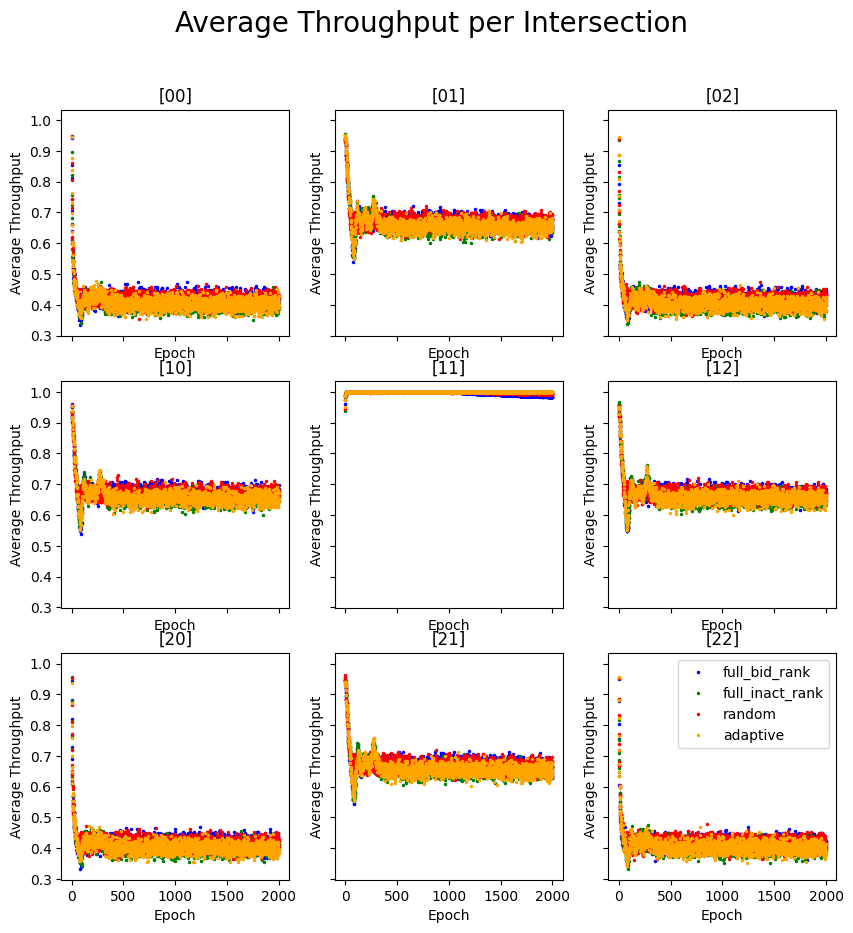

In [51]:
plt.clf()
average_throughput_per_intersection_history_results = []
for sim in results_to_use:
    average_throughput_per_intersection_history_results.append(
        all_sim_results[sim]['average_throughput_per_intersection'])

fig, axs = plt.subplots(
    average_throughput_per_intersection_history_results[0].shape[0], 
    average_throughput_per_intersection_history_results[0].shape[1], sharex=True, sharey=True, figsize=(10, 10))

for i, history in enumerate(average_throughput_per_intersection_history_results):
    plot_throughput_history(history, results_to_use[i], sim_colours[i], axs)

fig.suptitle('Average Throughput per Intersection ', fontsize=20)
plt.legend()
plt.show()


## 4. Average Max Time Waited per Intersection <a id="4"></a>

In [52]:
def plot_max_time_waited_history(max_time_waited_history_per_intersection, label, colour, axs):
    for i in range(max_time_waited_history_per_intersection.shape[0]):
        for j in range(max_time_waited_history_per_intersection.shape[0]):
            axs[i, j].plot(
                max_time_waited_history_per_intersection[i, j], 'o', markersize=1.5, color=colour, label=label)
            axs[i, j].set_title('[' + str(i) + str(j) + ']')
            axs[i, j].set_xlabel('Epoch')
            axs[i, j].set_ylabel('Average Max Time Waited')

<Figure size 640x480 with 0 Axes>

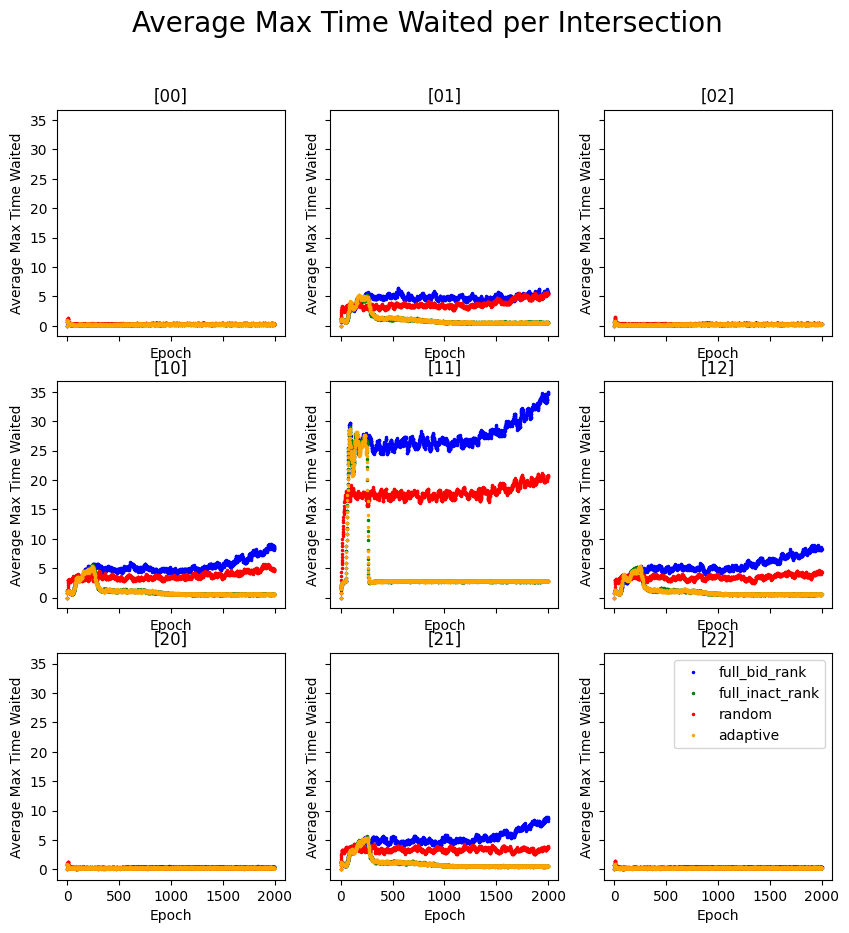

In [53]:
plt.clf()
average_max_time_waited_per_intersection_history_results = []
for sim in results_to_use:
    average_max_time_waited_per_intersection_history_results.append(
        all_sim_results[sim]['average_max_time_waited_per_intersection_history'])

fig, axs = plt.subplots(
    average_max_time_waited_per_intersection_history_results[0].shape[0], 
    average_max_time_waited_per_intersection_history_results[0].shape[1], sharex=True, sharey=True, figsize=(10, 10))

for i, history in enumerate(average_max_time_waited_per_intersection_history_results):
    plot_max_time_waited_history(history, results_to_use[i], sim_colours[i], axs)

fig.suptitle('Average Max Time Waited per Intersection ', fontsize=20)
plt.legend()
plt.show()


## 5. Average Parameter Valuations per Intersection <a id="5"></a>

In [54]:
def plot_average_valuation_per_parameter_per_intersection(rewards, parameters, counts, label, colour, axs):
    for i in range(rewards.shape[0]):
        for j in range(rewards.shape[0]):
            axs[i, j].scatter(
                parameters[:, 0], rewards[i, j, :], s=counts[i, j, :], marker="o", c=colour, label=label)
            axs[i, j].set_title('[' + str(i) + str(j) + ']')
            axs[i, j].set_xlabel('Delay Boost')
            axs[i, j].set_ylabel('Average Reward')

<Figure size 640x480 with 0 Axes>

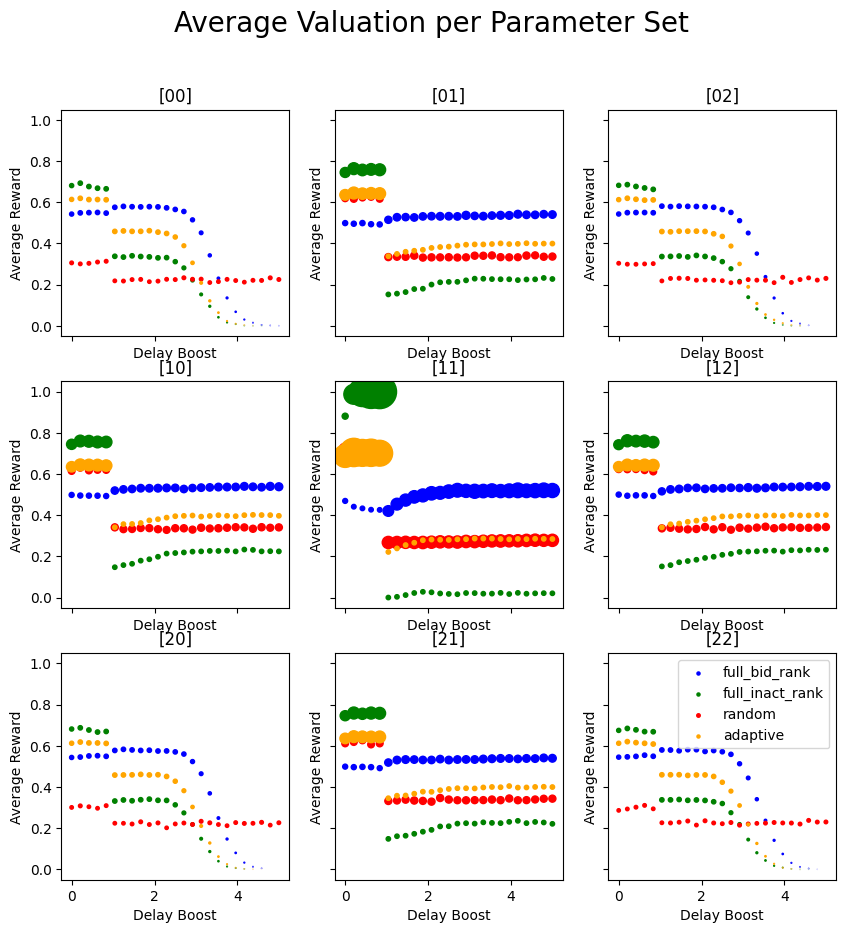

In [55]:
plt.clf()
average_valuations_per_parameter_per_intersection = []
parameters_used = []
counts_per_paramter = []
for sim in results_to_use:
    average_valuations_per_parameter_per_intersection.append(
        all_sim_results[sim]['average_reward_per_parameter_set_per_intersection_rewards'])
    parameters_used.append(
        all_sim_results[sim]['average_reward_per_parameter_set_per_intersection_parameters'])
    counts_per_paramter.append(
        all_sim_results[sim]['average_reward_per_parameter_set_per_intersection_counts'])


fig, axs = plt.subplots(
    average_valuations_per_parameter_per_intersection[0].shape[0],
    average_valuations_per_parameter_per_intersection[0].shape[1], sharex=True, sharey=True, figsize=(10, 10))

for i, reward_set in enumerate(average_valuations_per_parameter_per_intersection):
    plot_average_valuation_per_parameter_per_intersection(
        reward_set, parameters_used[i], counts_per_paramter[i],  results_to_use[i], sim_colours[i], axs)

fig.suptitle('Average Valuation per Parameter Set ', fontsize=20)
plt.legend()
plt.show()
